# Hate Speech Detector 2.0
---
**Lexical text classifier**
1. Load sanitized tweets data about polish courts.
2. Lemmatize loaded tweets.
3. Load PAC scores for tweets from appropriate .csv file.
4. Find optimal thresholding values of above measures calculating classification accuracy (and other) as a quality score.
5. Visualize results.
6. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import os
import csv

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import morfeusz2
import itertools

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
FULL_HATE_TYPES = ['wyzywanie', 'grożenie', 'wykluczanie', 'odczłowieczanie', 'poniżanie',
                   'stygmatyzacja', 'szantaż']
HATE_TYPES = ['wyz', 'groz', 'wyk', 'odcz', 'pon', 'styg', 'szan']

**Polish stopwords**

In [3]:
with open('data/other/polish_stopwords.txt', 'r') as f:
    polish_stopwords = f.read().split('\n')[:-1]
polish_stopwords[:10]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']

## Data loading

### Tweet classes

In [4]:
df_data = pd.read_csv('data/sady_main/sady_combined.csv')
df_data = df_data[['id', 'tweet', 'wyzywanie', 'grożenie', 'wykluczanie', 'odczłowieczanie', 'poniżanie',
                   'stygmatyzacja', 'szantaż']]
ids  = df_data['id']
tweets = df_data['tweet']
df_data = df_data.notnull().astype('int')
df_data['id'] = ids
df_data['tweet'] = tweets
del ids, tweets
df_data.head(2)

,id,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,Dokładnie! Dlatego trzeba komuchów gonić prze...,1,0,0,0,0,0,0
1,1,Polska Polityka: Sądy bardziej bezkarne niż w ...,0,0,0,0,0,0,0


### Lemmatized tweets

In [5]:
morf = morfeusz2.Morfeusz()

In [6]:
def lemmatize_text(text):
    analysis = morf.analyse(text.replace('#', ''))
    lemmas = list([])
    
    i, j, interp = analysis[0]
    last_ij, last_lemma = (i, j), interp[1].split(':')[0].lower()
    lemmas.append(last_lemma)
    
    for i, j, interp in analysis[1:]:
        lemma = interp[1].split(':')[0].lower()
        if not (last_ij == (i, j) and last_lemma == lemma):
            lemmas.append(lemma)
        
        last_ij = (i, j)
        last_lemma = lemma
    
    lemm_text = ' '.join(lemmas)
    lemm_text = lemm_text.replace(' [ . . . ]', '')
    
    return lemm_text

In [7]:
lemm_tweets = list([lemmatize_text(tweet) for tweet in df_data['tweet']])
df_data['lemmatized'] = lemm_tweets
del lemm_tweets
df_data.head(2)

,id,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż,lemmatized
0,0,Dokładnie! Dlatego trzeba komuchów gonić prze...,1,0,0,0,0,0,0,dokładnie ! dlatego trzeba komuch gonić przed ...
1,1,Polska Polityka: Sądy bardziej bezkarne niż w ...,0,0,0,0,0,0,0,polska polski polityka polityk sąd bardzo bez...


### Hateful phrases

In [8]:
lemm_files = ['lemm_wyz.txt', 'lemm_groz.txt', 'lemm_wyk.txt', 'lemm_odcz.txt', 'lemm_pon.txt',
              'lemm_styg.txt', 'lemm_szan.txt']
syn_files = ['syn_wyz.txt', 'syn_groz.txt', 'syn_wyk.txt', 'syn_odcz.txt', 'syn_pon.txt',
             'syn_styg.txt', 'syn_szan.txt']

In [9]:
lemmatized_phrases, synonymic_phrases = list([]), list([])

for lemm_file in lemm_files:
    with open(f'data/hateful_phrases/{lemm_file}', 'r') as f:
        lemmatized_phrases.append(f.read().split('\n')[:-1])

for syn_file in syn_files:
    with open(f'data/hateful_phrases/{syn_file}', 'r') as f:
        synonymic_phrases.append(f.read().split('\n')[:-1])

In [10]:
lemmatized_phrases[0][:5]

['komuch',
 'gonić komuch',
 'kwaśniewski idiota',
 'pojebać kto ktoś być',
 'polityk kłapać dziób']

In [11]:
synonymic_phrases[0][:5]

['pojebać',
 'czuj czuja czuć ?',
 'prezydent wart warta wart szacunek',
 'ch . m miasto morze męski metr . wiek wielki wiersz wieś wyspa . d dawny dom dzień .',
 'chuj dupa']

## PAC (Phrase Appearance Coefficient) calculation

In [12]:
def calculate_PAC(text, phrase, lemmatized=False, stopwords=[]):
    
    t = text if lemmatized else lemmatize_text(text)
    p = phrase if lemmatized else lemmatize_text(phrase)
    
    t_words = list(filter(lambda x: x not in stopwords, t.split(' ')))
    p_words = list(filter(lambda x: x not in stopwords, p.split(' ')))
    
    assert (len(t_words) > 0), 'The examined text must have at least one non-stopword word!'
    
    if len(p_words) > 1:
        occurences = list([[i for i, x in enumerate(t_words) if x == p_w] for p_w in p_words])
        occurences = list([o for o in occurences if len(o) > 0])

        orders = list(itertools.product(*occurences))
        order_pairs_list = list([[tuple((o[i], o[i+1])) for i, oi in enumerate(o[:-1])] for o in orders])

        coeffs = list([sum([1. if op[0]<op[1] else -1. for op in ops])/(len(p_words) - 1)
                       for ops in order_pairs_list])

        return (np.min(coeffs), np.mean(coeffs), np.max(coeffs))
    elif len(p_words) == 1:
        return (1., 1., 1.) if p_words[0] in t_words else (0., 0., 0.)
    else:
        return (0., 0., 0.)

In [13]:
df_pac_scores = pd.read_csv('data/sady_main/sady_pac_scores.csv')
df_pac_scores.head(2)

,id,tweet,wyz_PAC_min,wyz_PAC_mean,wyz_PAC_max,wyz_label,groz_PAC_min,groz_PAC_mean,groz_PAC_max,groz_label,...,pon_PAC_max,pon_label,styg_PAC_min,styg_PAC_mean,styg_PAC_max,styg_label,szan_PAC_min,szan_PAC_mean,szan_PAC_max,szan_label
0,0,Dokładnie! Dlatego trzeba komuchów gonić prze...,-1.0,0.002574,1.0,1,-0.500000,-0.003554,0.00,0,...,0.250000,0,-0.5,0.000698,0.5,0,0.0,0.0,0.0,0
1,1,Polska Polityka: Sądy bardziej bezkarne niż w ...,0.0,0.000000,0.0,0,-0.333333,-0.000708,0.25,0,...,0.333333,0,-0.5,0.000097,0.5,0,0.0,0.0,0.0,0


## Optimal thresholding values for min, mean and max scores

*First list all distinct values of PAC scores for min, mean and max.*

In [14]:
unique_scores = dict({})
accuracy_scores = dict({})
f1_scores = dict({})

for hate_type in tqdm(HATE_TYPES):
    for sc in ['min', 'mean', 'max']:
        scores = np.array(df_pac_scores[f'{hate_type}_PAC_{sc}'])
        y_true = np.array(df_pac_scores[f'{hate_type}_label'])
        acc_scores, f_scores = list([]), list([])
        
        for u_score in np.unique(scores):
            y_pred = np.array([1 if s >= u_score else 0 for s in scores])
            
            acc_scores.append(accuracy_score(y_true=y_true, y_pred=y_pred))
            f_scores.append(f1_score(y_true=y_true, y_pred=y_pred, average=None, zero_division=1.)[1])
        
        unique_scores[f'{hate_type}_{sc}'] = np.unique(scores)
        accuracy_scores[f'{hate_type}_{sc}'] = np.array(acc_scores)
        f1_scores[f'{hate_type}_{sc}'] = np.array(f_scores)

In [15]:
def accuracy_f1_plot(x_thrs, acc_scores, f_scores,
                     title='Accuracy & f1 scores for thresholding values of min, mean and max PAC.',
                     save_file=None):
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    
    ax[0].set_title('Minimum PAC')
    ax[0].set_ylabel('Score')
    ax[0].set_xlabel('Threshold')
    ax[0].plot(x_thrs[0], acc_scores[0], label='accuracy')
    ax[0].plot(x_thrs[0], f_scores[0], label='f1 score')
    
    mx, my = x_thrs[0][np.argmax(acc_scores[0])], np.max(acc_scores[0]) 
    ax[0].scatter([mx], [my], s=200, marker='*')
    ax[0].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
    mx, my = x_thrs[0][np.argmax(f_scores[0])], np.max(f_scores[0]) 
    ax[0].scatter([mx], [my], s=200, marker='*')
    ax[0].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
    
    ax[1].set_title('Mean PAC')
    ax[1].set_ylabel('Score')
    ax[1].set_xlabel('Threshold')
    ax[1].plot(x_thrs[1], acc_scores[1])
    ax[1].plot(x_thrs[1], f_scores[1])
    
    mx, my = x_thrs[1][np.argmax(acc_scores[1])], np.max(acc_scores[1]) 
    ax[1].scatter([mx], [my], s=200, marker='*', label='max accuracy')
    ax[1].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
    mx, my = x_thrs[1][np.argmax(f_scores[1])], np.max(f_scores[1]) 
    ax[1].scatter([mx], [my], s=200, marker='*', label='max f1 score')
    ax[1].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
    
    ax[2].set_title('Maximum PAC')
    ax[2].set_ylabel('Score')
    ax[2].set_xlabel('Threshold')
    ax[2].plot(x_thrs[2], acc_scores[2])
    ax[2].plot(x_thrs[2], f_scores[2])
    
    mx, my = x_thrs[2][np.argmax(acc_scores[2])], np.max(acc_scores[2]) 
    ax[2].scatter([mx], [my], s=200, marker='*')
    ax[2].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
    mx, my = x_thrs[2][np.argmax(f_scores[2])], np.max(f_scores[2]) 
    ax[2].scatter([mx], [my], s=200, marker='*')
    ax[2].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
    
    h, l = ax[0].get_legend_handles_labels()
    fig.legend(h, l, loc='upper left')
    h, l = ax[1].get_legend_handles_labels()
    fig.legend(h, l, loc='upper right')
    
    fig.suptitle(title)
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
    plt.show()

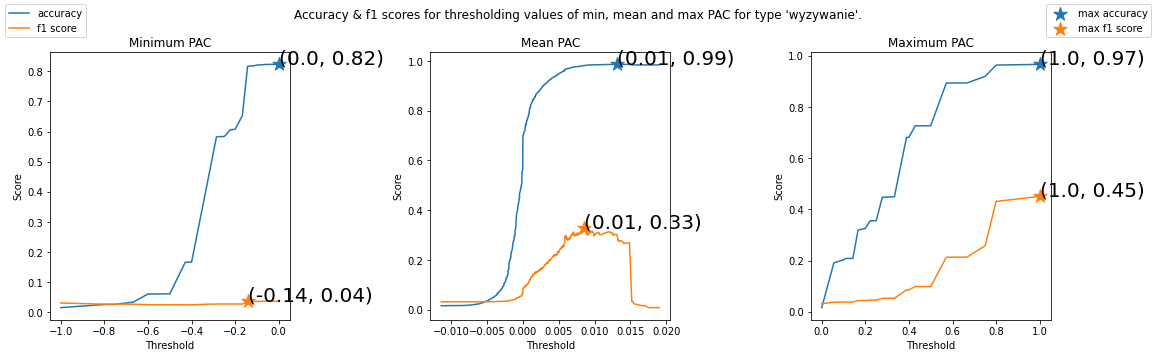

In [16]:
accuracy_f1_plot(
    (unique_scores['wyz_min'], unique_scores['wyz_mean'], unique_scores['wyz_max']),
    (accuracy_scores['wyz_min'], accuracy_scores['wyz_mean'], accuracy_scores['wyz_max']),
    (f1_scores['wyz_min'], f1_scores['wyz_mean'], f1_scores['wyz_max']),
    title='Accuracy & f1 scores for thresholding values of min, mean and max PAC for type \'wyzywanie\'.',
    save_file='charts/lexical_classifier/acc_f1_wyz.png'
)

As the plots show the thresholds for min, mean and max PAC score for 'wyzywanie' should be appropriately: -0.14; 0.01; 1.0

In [17]:
MIN_WYZ, MEAN_WYZ, MAX_WYZ = -0.14, 0.01, 1.0

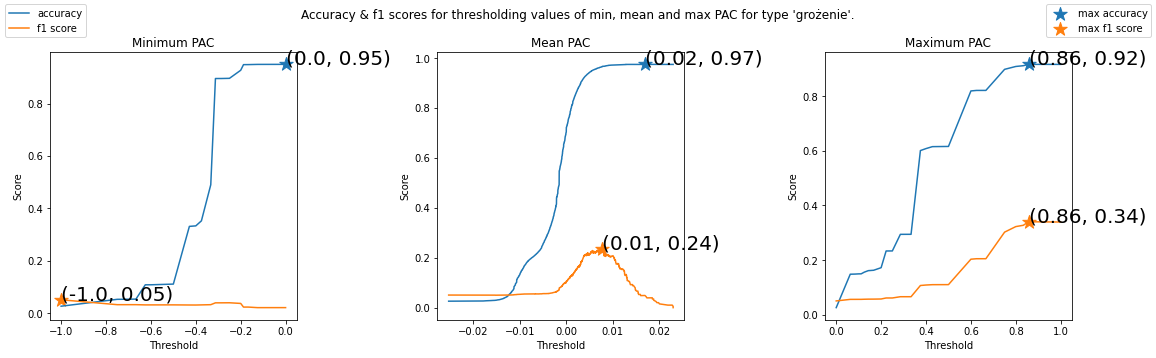

In [18]:
accuracy_f1_plot(
    (unique_scores['groz_min'], unique_scores['groz_mean'], unique_scores['groz_max']),
    (accuracy_scores['groz_min'], accuracy_scores['groz_mean'], accuracy_scores['groz_max']),
    (f1_scores['groz_min'], f1_scores['groz_mean'], f1_scores['groz_max']),
    title='Accuracy & f1 scores for thresholding values of min, mean and max PAC for type \'grożenie\'.',
    save_file='charts/lexical_classifier/acc_f1_groz.png'
)

As the plots show the thresholds for min, mean and max PAC score for 'grożenie' should be appropriately: -1.; 0.01; 0.86

In [19]:
MIN_GROZ, MEAN_GROZ, MAX_GROZ = -1., 0.01, 0.86

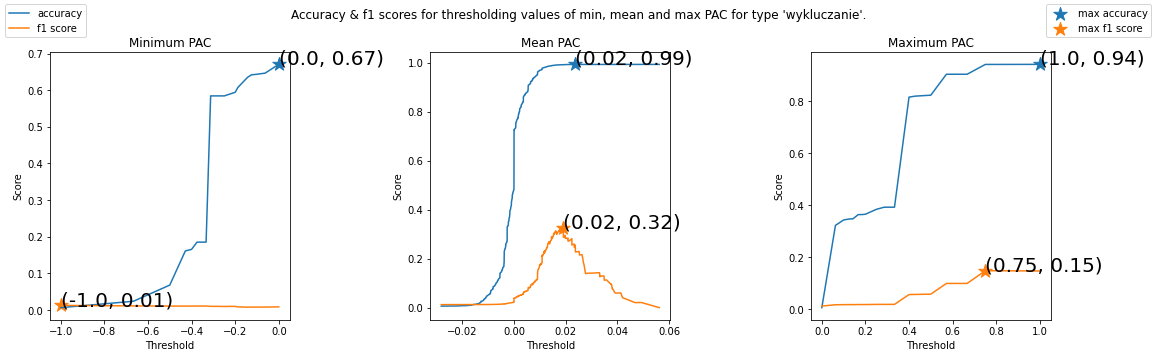

In [20]:
accuracy_f1_plot(
    (unique_scores['wyk_min'], unique_scores['wyk_mean'], unique_scores['wyk_max']),
    (accuracy_scores['wyk_min'], accuracy_scores['wyk_mean'], accuracy_scores['wyk_max']),
    (f1_scores['wyk_min'], f1_scores['wyk_mean'], f1_scores['wyk_max']),
    title='Accuracy & f1 scores for thresholding values of min, mean and max PAC for type \'wykluczanie\'.',
    save_file='charts/lexical_classifier/acc_f1_wyk.png'
)

As the plots show the thresholds for min, mean and max PAC score for 'wykluczanie' should be appropriately: -1.0; 0.02; 0.75

In [21]:
MIN_WYK, MEAN_WYK, MAX_WYK = -1., 0.02, 0.75

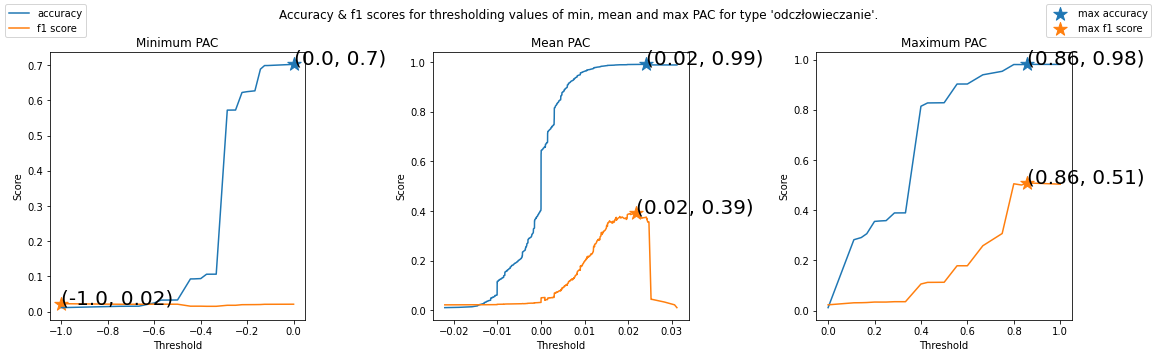

In [22]:
accuracy_f1_plot(
    (unique_scores['odcz_min'], unique_scores['odcz_mean'], unique_scores['odcz_max']),
    (accuracy_scores['odcz_min'], accuracy_scores['odcz_mean'], accuracy_scores['odcz_max']),
    (f1_scores['odcz_min'], f1_scores['odcz_mean'], f1_scores['odcz_max']),
    title='Accuracy & f1 scores for thresholding values of min, mean and max PAC for type \'odczłowieczanie\'.',
    save_file='charts/lexical_classifier/acc_f1_odcz.png'
)

As the plots show the thresholds for min, mean and max PAC score for 'odczłowieczanie' should be appropriately: -1.; 0.02; 0.86

In [23]:
MIN_ODCZ, MEAN_ODCZ, MAX_ODCZ = -1., 0.02, 0.86

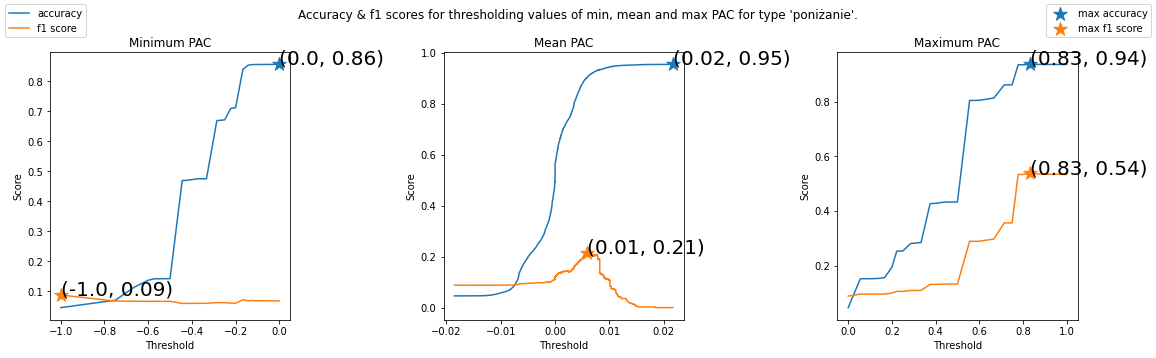

In [24]:
accuracy_f1_plot(
    (unique_scores['pon_min'], unique_scores['pon_mean'], unique_scores['pon_max']),
    (accuracy_scores['pon_min'], accuracy_scores['pon_mean'], accuracy_scores['pon_max']),
    (f1_scores['pon_min'], f1_scores['pon_mean'], f1_scores['pon_max']),
    title='Accuracy & f1 scores for thresholding values of min, mean and max PAC for type \'poniżanie\'.',
    save_file='charts/lexical_classifier/acc_f1_pon.png'
)

As the plots show the thresholds for min, mean and max PAC score for 'poniżanie' should be appropriately: -1.; 0.01; 0.83

In [25]:
MIN_PON, MEAN_PON, MAX_PON = -1., 0.01, 0.83

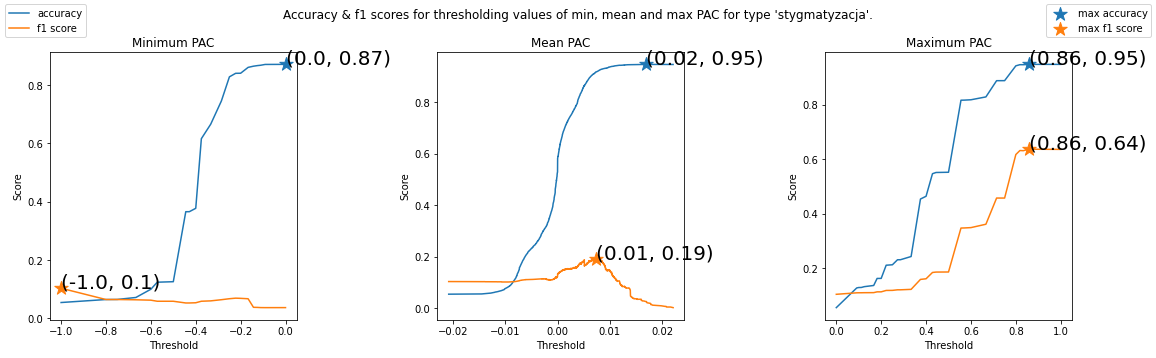

In [26]:
accuracy_f1_plot(
    (unique_scores['styg_min'], unique_scores['styg_mean'], unique_scores['styg_max']),
    (accuracy_scores['styg_min'], accuracy_scores['styg_mean'], accuracy_scores['styg_max']),
    (f1_scores['styg_min'], f1_scores['styg_mean'], f1_scores['styg_max']),
    title='Accuracy & f1 scores for thresholding values of min, mean and max PAC for type \'stygmatyzacja\'.',
    save_file='charts/lexical_classifier/acc_f1_styg.png'
)

As the plots show the thresholds for min, mean and max PAC score for 'stygmatyzacja' should be appropriately: -1.; 0.01; 0.86

In [27]:
MIN_STYG, MEAN_STYG, MAX_STYG = -1., 0.01, 0.86

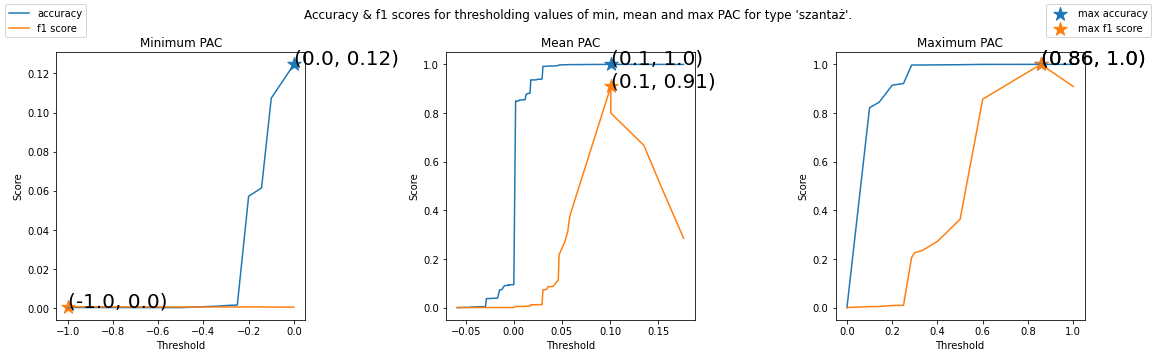

In [28]:
accuracy_f1_plot(
    (unique_scores['szan_min'], unique_scores['szan_mean'], unique_scores['szan_max']),
    (accuracy_scores['szan_min'], accuracy_scores['szan_mean'], accuracy_scores['szan_max']),
    (f1_scores['szan_min'], f1_scores['szan_mean'], f1_scores['szan_max']),
    title='Accuracy & f1 scores for thresholding values of min, mean and max PAC for type \'szantaż\'.',
    save_file='charts/lexical_classifier/acc_f1_szan.png'
)

As the plots show the thresholds for min, mean and max PAC score for 'szantaż' should be appropriately: -1.; 0.1; 0.86

In [29]:
MIN_SZAN, MEAN_SZAN, MAX_SZAN = -1., 0.1, 0.86

Put every thresholding values into dictionary.

In [30]:
THRS = dict({
    'wyz_min': MIN_WYZ, 'wyz_mean': MEAN_WYZ, 'wyz_max': MAX_WYZ,
    'groz_min': MIN_GROZ, 'groz_mean': MEAN_GROZ, 'groz_max': MAX_GROZ,
    'wyk_min': MIN_WYK, 'wyk_mean': MEAN_WYK, 'wyk_max': MAX_WYK,
    'odcz_min': MIN_ODCZ, 'odcz_mean': MEAN_ODCZ, 'odcz_max': MAX_ODCZ,
    'pon_min': MIN_PON, 'pon_mean': MEAN_PON, 'pon_max': MAX_PON,
    'styg_min': MIN_STYG, 'styg_mean': MEAN_STYG, 'styg_max': MAX_STYG,
    'szan_min': MIN_SZAN, 'szan_mean': MEAN_SZAN, 'szan_max': MAX_SZAN,
})

## Classifier tests

In [31]:
def calculate_classes_PACs(tweet_text):
    scores = dict({})
        
    for hate_type, l_phrases, s_phrases in zip(HATE_TYPES, lemmatized_phrases, synonymic_phrases):
        sc_min, sc_mean, sc_max = list([]), list([]), list([])

        for l_phrase in l_phrases:
            mn, mean, mx = calculate_PAC(tweet_text, l_phrase, lemmatized=True, stopwords=polish_stopwords)
            sc_min.append(mn)
            sc_mean.append(mean)
            sc_max.append(mx)

        for s_phrase in s_phrases:
            mn, mean, mx = calculate_PAC(tweet_text, s_phrase, lemmatized=True, stopwords=polish_stopwords)
            sc_min.append(mn)
            sc_mean.append(mean)
            sc_max.append(mx)

        scores[f'{hate_type}_min'] = np.min(sc_min)
        scores[f'{hate_type}_mean'] = np.mean(sc_mean)
        scores[f'{hate_type}_max'] = np.max(sc_max)
        del sc_min, sc_mean, sc_max
    
    return scores

def predict(scores, long_names=True):
    pred = np.zeros(len(HATE_TYPES))
    
    for i, ht in zip(range(len(HATE_TYPES)), HATE_TYPES):
        if scores[f'{ht}_min'] >= THRS[f'{ht}_min'] and\
           scores[f'{ht}_mean'] >= THRS[f'{ht}_mean'] and\
           scores[f'{ht}_max'] >= THRS[f'{ht}_max']:
            pred[i] = 1.
    
    if long_names:
        return dict(zip(FULL_HATE_TYPES, pred))
    else:
        return dict(zip(HATE_TYPES, pred))

### Test for all data
Get predictions for all data considering on each of 7 hate speech types and overall.

In [32]:
conf_matrices = dict({})
y_true = df_pac_scores[f'{hate_type}_label'].values
conf_matrix = np.zeros((2, 2), dtype=np.int32)

for hate_type in HATE_TYPES:
    y_min = df_pac_scores[f'{hate_type}_PAC_min'].values
    y_mean = df_pac_scores[f'{hate_type}_PAC_mean'].values
    y_max = df_pac_scores[f'{hate_type}_PAC_max'].values
    
    min_thr = THRS[f'{hate_type}_min']
    mean_thr = THRS[f'{hate_type}_mean']
    max_thr = THRS[f'{hate_type}_max']
    
    y_pred = np.array([ 1 if mn >= min_thr and me >= mean_thr and mx >= max_thr else 0
                       for mn, me, mx in zip(y_min, y_mean, y_max)])
    
    conf_matrices[f'{hate_type}'] = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    conf_matrix += conf_matrices[f'{hate_type}']
    
    del y_min, y_mean, y_max, min_thr, mean_thr, max_thr

conf_matrices['overall'] = conf_matrix
del y_true, conf_matrix

In [33]:
conf_matrices

{'wyz': array([[15159,    37],
        [    6,     0]]),
 'groz': array([[15072,   124],
        [    6,     0]]),
 'wyk': array([[15158,    38],
        [    6,     0]]),
 'odcz': array([[15146,    50],
        [    6,     0]]),
 'pon': array([[15065,   131],
        [    6,     0]]),
 'styg': array([[15041,   155],
        [    6,     0]]),
 'szan': array([[15196,     0],
        [    2,     4]]),
 'overall': array([[105837,    535],
        [    38,      4]], dtype=int32)}

In [34]:
def accuracy_cm(cm):
    return (cm[1][1] + cm[0][0])/(cm[1][1] + cm[1][0] + cm[0][1] + cm[0][0])

def f1_cm(cm):
    return 2*cm[1][1]/(2*cm[1][1] + cm[1][0] + cm[0][1])

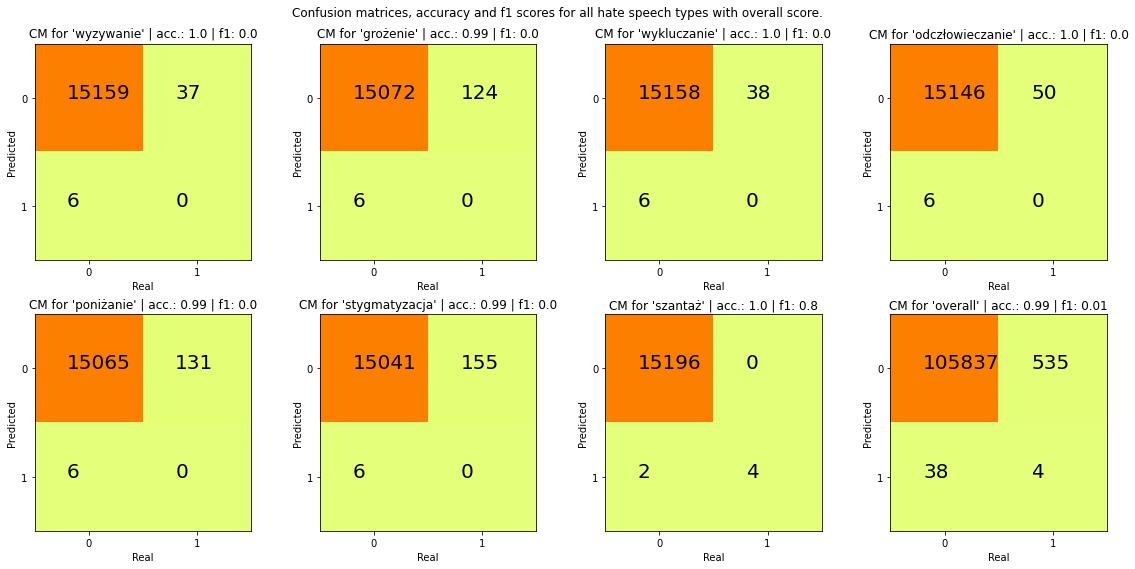

In [35]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
positions = list([tuple((i, j)) for i in range(2) for j in range(4)])

for i, (p, ht, fht) in enumerate(zip(positions, HATE_TYPES + ['overall'], FULL_HATE_TYPES + ['overall'])):
    
    acc = np.round(accuracy_cm(conf_matrices[ht]), 2)
    f1 = np.round(f1_cm(conf_matrices[ht]), 2)
    ax[p[0]][p[1]].set_title(f'CM for \'{fht}\' | acc.: {acc} | f1: {f1}')
    ax[p[0]][p[1]].set_ylabel('Predicted')
    ax[p[0]][p[1]].set_xlabel('Real')
    
    ax[p[0]][p[1]].imshow(conf_matrices[ht], interpolation='nearest', cmap=plt.cm.Wistia)
    tick_marks = np.arange(2)
    ax[p[0]][p[1]].set_xticks(tick_marks)
    ax[p[0]][p[1]].set_yticks(tick_marks)
    
    for i in range(2):
        for j in range(2):
            ax[p[0]][p[1]].text(j - 0.2, i, str(conf_matrices[ht][i][j]), fontsize=20)

fig.suptitle('Confusion matrices, accuracy and f1 scores for all hate speech types with overall score.')

plt.tight_layout()
plt.savefig('charts/lexical_classifier/conf_matrices.png')
plt.show()

### Test 1

In [36]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
test_text1

'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'

In [37]:
test_text1_lemmatized = lemmatize_text(test_text1)
test_text1_lemmatized

'nie on nie . po prosty skorumpować zgniły zatruć przez ty i twój twoi twoja twoje twój koleś sąd , który swój swoje zawsze wybronić'

In [38]:
scores1 = calculate_classes_PACs(test_text1_lemmatized)
predict(scores1)

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'stygmatyzacja': 1.0.

### Test 2

In [39]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
test_text2

'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'

In [40]:
test_text2_lemmatized = lemmatize_text(test_text2)
test_text2_lemmatized

'ten to nie on nie sąd , ten to człowiek lud człowiek , sędzia , zdrajca barbarzyńca barbarzyniec w toga z mafijny organizacja zdradziecko zbrodniczy który muszy musieć musić musza zostać wyeliminować'

In [41]:
scores2 = calculate_classes_PACs(test_text2_lemmatized)
predict(scores2)

{'wyzywanie': 0.0,
 'grożenie': 1.0,
 'wykluczanie': 1.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 1.0,
 'stygmatyzacja': 1.0,
 'szantaż': 0.0}

Empirically everything OK! Hooray!

### Test 3

In [42]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
test_text3

'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '

In [43]:
test_text3_lemmatized = lemmatize_text(test_text3)
test_text3_lemmatized

'przed repolonizacja teren wyczyścić ! raz , dwa ! nie on nie patrzeć na bok ! sąd sąd , ale media medium muszy musieć musić musza bycie być nasz nasze media medium'

In [44]:
scores3 = calculate_classes_PACs(test_text3_lemmatized)
predict(scores3)

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'grożenie': 1.0.